In [ ]:
# energy reconstruction for monopole
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score
def show_MC_data(mndata_all):
    plt.scatter(np.log10(mndata_all["trueE"]/1e8), mndata_all["NuW3"],s=0.5)
    plt.xlim(0.3,2)
    plt.ylim(0.3,3)
    plt.title(f"Data: 1E8~1E10 GeV, eSlope=-2, size: {len(mndata_all)}")
    plt.xlabel("log10 trueE/1e8 [TeV] in bkg scale")
    plt.ylabel("NuW3")
    plt.show()

    plt.hist(mndata_all["NuW3"]-np.log10(mndata_all["trueE"]/1e8), bins=50, density=True, alpha=0.5, label=f"NuW3, width={np.std(mndata_all['NuW3']-np.log10(mndata_all['trueE']/1e8)):.2f}")
    plt.hist(mndata_all["recE"]-np.log10(mndata_all["trueE"]/1e8), bins=50, density=True, alpha=0.5,range=(-1,2), label=f"recE NpE1, width={np.std(mndata_all['recE']-np.log10(mndata_all['trueE']/1e8)):.2f}")
    plt.legend()
    plt.title(f"Data: 1E8~1E10 GeV, eSlope=-2, size: {len(mndata_all)}")
    plt.xlabel("NuW3 - log10 trueE/1e8 [TeV] ")
    plt.ylabel("Density")
    plt.show()


def analyze_variable(all_data, energy_bins, variable="NuW3", 
                     ranges=(0.5, 3.5), target_fraction=[0.05, 0.95], 
                     ref_energy=1e9, ref_bounds=None):

    # --- 按能区收集数据 ---
    groups, labels = [], []
    for (emin, emax) in energy_bins:
        mask = (all_data['trueE'] >= emin) & (all_data['trueE'] < emax)
        subset = all_data.loc[mask, variable]
        if len(subset) > 0:
            groups.append(subset)
            labels.append(f'{emin:.1e}-{emax:.1e} GeV')

    # --- 直方图 ---
    plt.figure(figsize=(8,6))
    plt.hist(all_data[variable], bins=50, density=True,
             histtype='step', linewidth=2, color='black', label='Total', range=ranges)

    plt.hist(groups, bins=50, stacked=True, density=True,
             alpha=0.7, label=labels, range=ranges)

    if ref_bounds is not None:
        plt.vlines(ref_bounds, ymin=0, ymax=0.1, color='r', linestyle='--',
                   label=f'{ref_energy:.1e} GeV [{ref_bounds[0]:.2f}, {ref_bounds[1]:.2f}]')
    # plt.yticks([i*0.2 for i in range(11)]) 
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.title(f'Stacked {variable} distribution in different trueE bins')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 取区间数据并画累积分布 ---
    if ref_bounds is None:
        return

    vmin, vmax = ref_bounds
    mask = (all_data[variable] >= vmin) & (all_data[variable] <= vmax)
    subset = all_data[mask].sort_values("trueE")

    cum_counts = np.arange(1, len(subset)+1)
    total_counts = len(subset)
    cum_fraction = cum_counts / total_counts

    idx_left = np.searchsorted(cum_fraction, target_fraction[0])
    idx_right = np.searchsorted(cum_fraction, target_fraction[1])

    energy_left = subset["trueE"].iloc[idx_left]
    energy_right = subset["trueE"].iloc[idx_right]

    print(f"{variable}: 比例达到 {target_fraction[0]:.2f} 时对应 trueE ≈ {energy_left:.3e} GeV")
    print(f"{variable}: 比例达到 {target_fraction[1]:.2f} 时对应 trueE ≈ {energy_right:.3e} GeV")

    plt.plot(np.log10(subset["trueE"]/1e8), cum_fraction, drawstyle="steps-post", 
             label=f"Fraction in {variable} [1%,99%] range")
    plt.plot(np.log10(subset["trueE"]/1e8), 1-cum_fraction, drawstyle="steps-post",
             label="1-Fraction above")

    plt.axhline(1.0, color="gray", linestyle="--")
    plt.hlines(target_fraction[0], np.log10(energy_left/1e8)-0.1,np.log10(energy_left/1e8)+0.1,color="r", linestyle="--", alpha=0.7,
                label=f'pollution frac={target_fraction}, trueE in [{energy_left:.3e}, {energy_right:.3e}]')
    plt.hlines(1-target_fraction[1], np.log10(energy_right/1e8)-0.1,np.log10(energy_right/1e8)+0.1,color="r", linestyle="--", alpha=0.7)
    plt.vlines(np.log10(energy_left/1e8), 0, 0.1, color="r", linestyle="--", alpha=0.7)
    plt.vlines(np.log10(energy_right/1e8), 0, 0.1, color="r", linestyle="--", alpha=0.7)
    plt.ylim(0, )
    plt.xlabel("log10 trueE / GeV")
    plt.ylabel("Cumulative fraction")
    plt.xlabel("log10 trueE / GeV")
    plt.ylabel("Cumulative fraction")
    plt.title(f"Cumulative fraction of events in {variable} range")
    plt.legend(loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.show()

    return energy_left, energy_right

def plot_variable_vs_energy(x, y, variable="NuW3",
                            emin=1e8, emax=1e10, 
                            delta_logE=0.1,
                            q_low=0.00, q_high=1):
   
    logE = x
    
    # mask = np.log10(all_data["trueE"]/1e8) < 1
    # all_data.loc[mask, 'NuW3'] = all_data.loc[mask, 'NuW3']

    var = y

    # 定义能量 bin
    # bins = np.arange(np.log10(emin), np.log10(emax) + delta_logE, delta_logE)
    bins=np.arange(np.min(logE), np.max(logE) + delta_logE, delta_logE)
    bin_centers, var_median, var_low, var_high = [], [], [], []

    for i in range(len(bins)-1):
        mask = (logE >= bins[i]) & (logE < bins[i+1])
        subset = var[mask]
        if len(subset) > 0:
            bin_centers.append((bins[i] + bins[i+1]) / 2)
            var_median.append(np.median(subset))
            var_low.append(np.quantile(subset, q_low))
            var_high.append(np.quantile(subset, q_high))

    bin_centers = np.array(bin_centers)
    var_median = np.array(var_median)
    var_low = np.array(var_low)
    var_high = np.array(var_high)

    # --- 绘图 ---
    # plt.figure(figsize=(8,6))
    # 用矩形柱显示范围
    for xc, low, high in zip(bin_centers, var_low, var_high):
        plt.fill_between([xc-delta_logE/2, xc+delta_logE/2], 
                         [low, low], [high, high], 
                         alpha=0.3, color="blue")
    # 中位数折线
    plt.plot(bin_centers, var_median, "o--", color="black", label="Median")

    plt.xlabel("log10(trueE/1e8 TeV in bkg scale)")
    plt.ylabel(variable)
    plt.title(f"{variable} range vs trueE")
    plt.grid(True, ls="--", alpha=0.5)
    plt.legend()
    plt.show()

    bins=100
    plt.hist2d(x, y, bins=bins, cmap="viridis",density=True)
    plt.colorbar(label="Counts")
    plt.xlabel("log10(trueE/1e8 TeV in bkg scale)")
    plt.ylabel(variable)
    plt.title(f"{variable} vs trueE")
    # plt.grid(True, ls="--", alpha=0.5)
    plt.show()

def plot_NuW3_refined(trueE, NuW3, NuW3_refined,
                            emin=0, emax=2, 
                            delta_logE=0.1,
                            q_low=0.00, q_high=1):
   
    logE = trueE
    var_0 = NuW3
    var_1 = NuW3_refined

    # 定义能量 bin
    bins = np.arange(emin, emax + delta_logE, delta_logE)
    bin_centers_0, var_median_0, var_low_0, var_high_0 = [], [], [], []
    bin_centers_1, var_median_1, var_low_1, var_high_1 = [], [], [], []
    
    # 新增：存储每个bin内数据的平均值
    bin_avg_0, bin_avg_1 = [], []

    for i in range(len(bins)-1):
        mask = (logE >= bins[i]) & (logE < bins[i+1])
        subset_0 = var_0[mask]
        subset_1 = var_1[mask]
        subset_logE = logE[mask]  # 获取当前bin内的logE值
        
        if len(subset_0) > 0:
            # 使用bin内数据的平均值作为x坐标
            bin_centers_0.append((bins[i] + bins[i+1]) / 2)
            bin_avg_0.append(np.mean(subset_logE))
            var_median_0.append(np.median(subset_0))
            var_low_0.append(np.quantile(subset_0, q_low))
            var_high_0.append(np.quantile(subset_0, q_high))
            
        if len(subset_1) > 0:
            # 使用bin内数据的平均值作为x坐标
            bin_centers_1.append((bins[i] + bins[i+1]) / 2)
            bin_avg_1.append(np.mean(subset_logE))
            var_median_1.append(np.median(subset_1))
            var_low_1.append(np.quantile(subset_1, q_low))
            var_high_1.append(np.quantile(subset_1, q_high))

    bin_avg_0 = np.array(bin_avg_0)
    var_median_0 = np.array(var_median_0)
    var_low_0 = np.array(var_low_0)
    var_high_0 = np.array(var_high_0)

    bin_avg_1 = np.array(bin_avg_1)
    var_median_1 = np.array(var_median_1)
    var_low_1 = np.array(var_low_1)
    var_high_1 = np.array(var_high_1)

    # --- 绘图 ---
    plt.figure(figsize=(8,6))
    
    # 用矩形柱显示范围 - 原始NuW3
    for xc, low, high in zip(bin_centers_0, var_low_0, var_high_0):
        plt.fill_between([xc-delta_logE/2, xc+delta_logE/2], 
                         [low, low], [high, high], 
                         alpha=0.3, color="gray")
    
    # 用矩形柱显示范围 - 修正后的NuW3
    for xc, low, high in zip(bin_centers_1, var_low_1, var_high_1):
        plt.fill_between([xc-delta_logE/2, xc+delta_logE/2], 
                         [low, low], [high, high], 
                         alpha=0.3, color="lightcoral")
    
    # 中位数折线 - 使用bin内数据的平均值作为x坐标
    plt.plot(bin_avg_0, var_median_0, "o-", color="black", linewidth=2, markersize=4, label="NuW3")
    plt.plot(bin_avg_1, var_median_1, "o-", color="red", linewidth=2, markersize=4, label="XGB NuW3")
    
    # 参考线
    plt.plot([emin, emax], [emin, emax], "--", linewidth=2, label="Reference Line")
    
    plt.xlabel("log10(trueE/1e8 TeV)")
    plt.ylabel("NuW3")
    plt.title("NuW3 vs True Energy")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.xlim(emin, emax)
    plt.tight_layout()
    plt.show()
    
    # 打印一些统计信息
    print(f"Number of bins with data: {len(bin_avg_0)}")
    print(f"X-axis range: {bin_avg_0.min():.3f} to {bin_avg_0.max():.3f}")

def  plot_estimation():
    # 训练后
    plot_NuW3_refined(y_test, X_test_p["NuW3"], y_pred, emin=0.2, emax=4.2, delta_logE=0.2, q_low=0.025, q_high=0.975)


    plt.scatter(y_test, y_pred, s=0.5)
    plt.plot([0.4, 4.1], [0.4, 4.1], color='r', linestyle='--')
    plt.title(f"Data: 1E8~1E10 GeV, eSlope=-2, size: {len(y_pred)}")
    plt.xlabel("log10 trueE/1e8 [TeV] in bkg scale")
    plt.ylabel("log10 recE / TeV")
    plt.grid()
    plt.show()


    plt.hist(y_pred-y_test, bins=50, density=True, alpha=0.5,label=f"XGB NuW3, width={np.std(y_pred-y_test):.2f}")
    plt.hist(X_test["NuW3"]-y_test, bins=50, density=True, alpha=0.5, label=f"NuW3, width={np.std(X_test['NuW3']-y_test):.2f}")
    plt.legend()
    plt.title(f"XGB error: 1E8~1E10 GeV, size: {len(y_pred)}")
    plt.xlabel("log10(E_rec[TeV]) - log10(E_true/1e8[TeV]) in bkg scale")
    plt.ylabel("Density")
    plt.show()

    # errbar(y_test, y_pred, X_test_p["recE"], labels=["XBG NuW3", "recE NpE1"])

    from sklearn.metrics import mean_absolute_error, r2_score
    import joblib  # 用于保存模型
    # loaded_model = joblib.load("./models/energy_correction_xgb_NuW3_8-12.pkl")
    # loaded_model = joblib.load("./models/energy_correction_MLP_optimized.pkl")['model']
    # loaded_model = joblib.load("./models/energy_correction_gb_NuW3.pkl")
    model = XGBRegressor()
    model.load_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
    mndata_point_90=pd.read_csv('./points/combined_points1e9_M_params.csv',sep=',')
    mndata_point_100=pd.read_csv('./points/combined_points1e10_M_params.csv',sep=',')
    bins=50
    ranges=(0,3)

    mndata_point_90['NuW3']=np.log10(mndata_point_90['NuW3'])
    mndata_point_100['NuW3']=np.log10(mndata_point_100['NuW3'])
    X_test_90=mndata_point_90[['NuW3','rec_theta']].values
    y_pred_90 = model.predict(X_test_90)
    X_test_100=mndata_point_100[['NuW3','rec_theta']].values
    y_pred_100 = model.predict(X_test_100)


    # 同样筛选中间90%的数据,左右两边分别去掉1%
    ratio_left=0.05
    ratio_right=1
    size_90=len(y_pred_90)
    size_100=len(y_pred_100)

    y_pred_90_selected=np.sort(y_pred_90,axis=0)[int(size_90*ratio_left):int(size_90*ratio_right)]
    y_pred_100_selected=np.sort(y_pred_100,axis=0)[int(size_100*ratio_left):int(size_100*ratio_right)]
    print(f"in bin=[{ratio_left},{ratio_right}], monopole 1e9 GeV recE(GBR_NuW3) Energy: [{y_pred_90_selected.min()}, {y_pred_90_selected.max()}], corresponding recE: [{10**y_pred_90_selected.min()*1e8: .4e}, {10**y_pred_90_selected.max()*1e8: .4e}]")
    print(f"in bin=[{ratio_left},{ratio_right}], monopole 1e10 GeV recE(GBR_NuW3) Energy: [{y_pred_100_selected.min()}, {y_pred_100_selected.max()}], corresponding recE: [{10**y_pred_100_selected.min()*1e8: .4e}, {10**y_pred_100_selected.max()*1e8: .4e}]")
    plt.hist(y_pred_90, bins=50, density=True, alpha=0.5, label='GBR: 1E9')
    plt.hist(y_pred_100, bins=50, density=True, alpha=0.5, label='GBR: 1E10')
    plt.vlines(y_pred_90_selected.min(), 0, 1, color='r', linestyle='--',label=f'[{ratio_left}, {ratio_right}]')
    plt.vlines(y_pred_90_selected.max(), 0, 1, color='r', linestyle='--')
    plt.vlines(y_pred_100_selected.min(), 0, 1, color='g', linestyle='--',label=f'[{ratio_left}, {ratio_right}]')
    plt.vlines(y_pred_100_selected.max(), 0, 1, color='g', linestyle='--')
    plt.xlabel('log10 recE / TeV')
    plt.ylabel('Density')
    plt.title('GBR RecE for Mono-point')
    plt.grid(True, ls='--', alpha=0.6)
    plt.legend()
    plt.show()

    plt.hist(y_pred_90-np.log10(mndata_point_90['trueE']/1e8), bins=50, alpha=0.5, density=True,label='1E9: log-error')
    plt.hist(y_pred_100-np.log10(mndata_point_100['trueE']/1e8), bins=50, alpha=0.5, density=True,label='1E10: log-error')
    plt.xlim(-1,1)
    plt.grid(True, ls='--', alpha=0.6)
    plt.xlabel('log-error')
    plt.ylabel('Density')
    plt.title('(GBR corrected) log-error for Mono-point: log10(recE)-log10(trueE/1e8 in bkg scale)')
    plt.legend()
    plt.show()

def XGB_train(X_train, y_train, X_test, y_test):
    
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=77,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))
    model.save_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
    # 加载模型
    # model = XGBRegressor()
    # model.load_model("./models/energy_correction_xgb_NuW3_8-12_higher.json")
    # joblib.dump(model, "./models/energy_correction_xgb_NuW3_8-12.pkl")

    return y_pred



def filter_data(mndata_all):
    theta_low = 0.0
    theta_high = 50/180.0 * np.pi
    rec_r_high=600
    rec_r_low=250
    rec_x = pd.to_numeric(mndata_all['rec_x'], errors='coerce')
    rec_y = pd.to_numeric(mndata_all['rec_y'], errors='coerce')
    rec_r = np.sqrt(rec_x**2 + rec_y**2)
    mndata_all['rec_r'] = rec_r
    mndata_all_filtered = mndata_all[
        (mndata_all['rec_theta'] >= theta_low) &
        (mndata_all['rec_theta'] <= theta_high) &
        (mndata_all['rec_r'] >= rec_r_low) &
        (mndata_all['rec_r'] <= rec_r_high) &
        (mndata_all['NuW3'] > 0)
    ].copy()
    del mndata_all
    mndata_all_filtered['trueE'] = pd.to_numeric(mndata_all_filtered['trueE'], errors='coerce')
    mndata_all_filtered['recE'] = pd.to_numeric(mndata_all_filtered['recE'], errors='coerce')
    mndata_all_filtered['NuW3'] = pd.to_numeric(mndata_all_filtered['NuW3'], errors='coerce')
    mndata_all_filtered['rec_theta'] = pd.to_numeric(mndata_all_filtered['rec_theta'], errors='coerce')
    return mndata_all_filtered

def pd_params_concat(params_list):
    mndata_all=pd.DataFrame()
    columns=['trueE','recE','NuW3','rec_theta','rec_x','rec_y']
    for params in params_list:
        mndata_all=pd.concat([mndata_all,params[columns]],ignore_index=True)
    return mndata_all

monopole_params89=pd.read_csv("./combined_1e8_1e9_M_params.csv")
monopole_params89=filter_data(monopole_params89)
monopole_params89=monopole_params89.sample(800)
monopole_params910=pd.read_csv("./combined_1e9_1e10_M_params.csv")
monopole_params910=filter_data(monopole_params910)
monopole_params1011=pd.read_csv("./combined_1e10_1e11_M_params.csv")
monopole_params1011=filter_data(monopole_params1011)
monopole_params1112=pd.read_csv("./combined_1e11_1e12_M_params.csv")
monopole_params1112=filter_data(monopole_params1112)
monopole_115_125_data=np.load('/home/zhonghua/Filt_Event/recE/filted_3.5_4.5_old_dataset.npz',allow_pickle=True)
# monopole_params115_125=pd.DataFrame(monopole_115_125_data['params'], columns=monopole_115_125_data['param_names'])
# monopole_params115_125=filter_data(monopole_params115_125)

# ,monopole_params115_125

mndata_all=pd_params_concat([monopole_params89,monopole_params910,monopole_params1011,
                             monopole_params1112])
mndata_all['NuW3'] = np.log10(mndata_all['NuW3'])
mndata_all_train=mndata_all.copy()



# 划分训练集和测试集
X_train_p, X_test_p, y_train, y_test = train_test_split(mndata_all_train[['NuW3','rec_theta']], np.log10(mndata_all_train['trueE']/1e8), test_size=0.2, random_state=42)
print(X_train_p.shape, X_test_p.shape, y_train.shape, y_test.shape)
X_train= X_train_p[['NuW3','rec_theta']]
X_test = X_test_p[['NuW3','rec_theta']]
y_pred = XGB_train(X_train, y_train, X_test, y_test)
# y_pred = GBR_train(X_train, y_train, X_test, y_test)
# y_pred = MLP_train(X_train, y_train, X_test, y_test)
# y_pred = MLP_train_optimized(X_train, y_train, X_test, y_test)
# y_pred = MLP_train_weighted(X_train, y_train, X_test, y_test)
# y_pred = compare_models(X_train, y_train, X_test, y_test)
# model = joblib.load("./models/energy_correction_gb_NuW3.pkl")
# y_pred = model.predict(X_test)

plot_estimation()


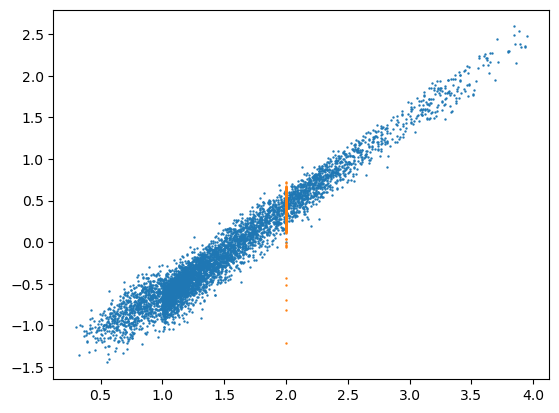

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mn_100=pd.read_csv("/home/zhonghua/Filt_Event/recE/points/combined_points1e10_M_params.csv")


plt.scatter(np.log10(mndata_all_train["trueE"]/1e8), mndata_all_train['NuW3'],s=0.5)
plt.scatter(np.log10(mn_100["trueE"]/1e8), np.log10(mn_100['NuW3']),s=0.5)
plt.show()


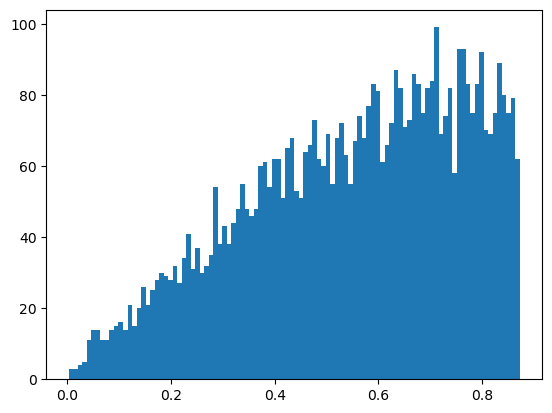

KeyError: 'rec_r'

In [ ]:
plt.hist(mndata_all['rec_theta'], bins=100, )
plt.show()



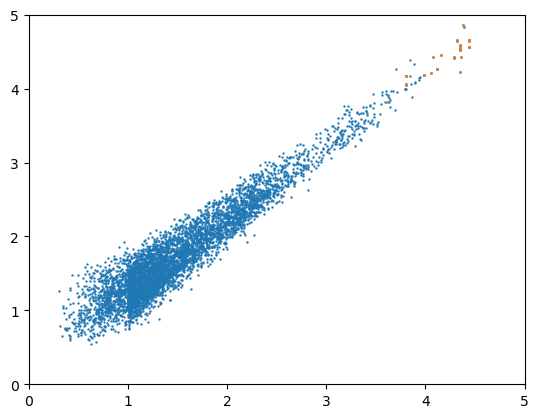

In [ ]:
monopole_115_125_data=np.load('/home/zhonghua/data/Dataset_Filted/Monopole/filted_all_recE_0.5_4.5_dataset_muon.npz',allow_pickle=True)
monopole_params115_125=pd.DataFrame(monopole_115_125_data['params'], columns=monopole_115_125_data['param_names'])
monopole_params115_125=filter_data(monopole_params115_125)
monopole_params115_125['trueE']=pd.to_numeric(monopole_params115_125['trueE'], errors='coerce')
mndata_all=pd.concat([mndata_all_train,monopole_params115_125],ignore_index=True)
mndata_all["trueE"] = pd.to_numeric(mndata_all["trueE"], errors='coerce')
plt.scatter(np.log10(mndata_all["trueE"]/1e8), mndata_all["NuW2"],s=0.5)
plt.scatter(np.log10(monopole_params115_125["trueE"]/1e8), monopole_params115_125["NuW2"],s=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
